# Digit Recognizer

## 1. Import Libraries/Frameworks

In [1]:
# import libraries/frameworks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import itertools

# set up seed random generator for NumPy
np.random.seed(2)

# import TrainTestSplit and ConusionMatrix functions from sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# import required functions from keras to build/train/test the model
import tensorflow as tf
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

# import src and model
from src import display_errors, plot_confusion_matrix
from model import defineModel

# set up displayer for jupyter notebook when displaying tables/images
%matplotlib inline

# set up seaborn
sns.set(style='white', context='notebook', palette='deep')

# check whether TensorFlow-gpu is enabled/installed
tf.test.is_gpu_available()

Using TensorFlow backend.


True

## 2. Data preparation

### 2.1 Load data

In [2]:
# Load the data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

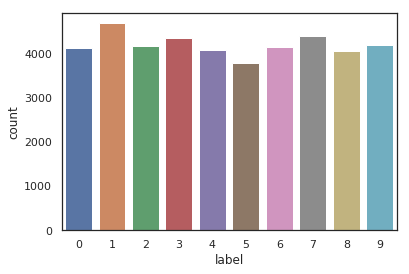

In [3]:
Y_train = train["label"]

# Drop 'label' column
X_train = train.drop(labels = ["label"],axis = 1) 

# free some space
del train 

g = sns.countplot(Y_train)

Y_train.value_counts()

### 2.2 Check for null and missing values

In [4]:
# Check the data
print("-------training-------")
X_train.isnull().any().describe()

-------training-------


count       784
unique        1
top       False
freq        784
dtype: object

In [5]:
print("---------test---------")
test.isnull().any().describe()

---------test---------


count       784
unique        1
top       False
freq        784
dtype: object

### 2.3 Normalization

In [6]:
# Normalize the data
X_train = X_train / 255.0
test = test / 255.0

### 2.3 Reshape

In [7]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
X_train = X_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

### 2.5 Label encoding

In [8]:
# Encode labels to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

### 2.6 Split training and valdiation set

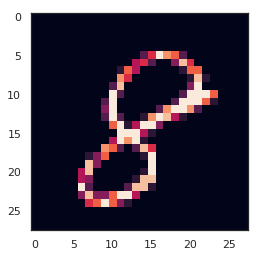

In [9]:
# Set the random seed
random_seed = 2
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=random_seed)
# Some examples
g = plt.imshow(X_train[0][:,:,0])

## 3. CNN

### 3.1 Define the model

In [10]:
model = defineModel()

### 3.2 Set the optimizer and annealer

In [11]:
# Define the optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
epochs = 60 # Turn epochs to 30 to get 0.9967 accuracy
batch_size = 86

### 3.3 Data augmentation

In [12]:
# Without data augmentation i obtained an accuracy of 0.98114
# history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs, 
#           validation_data = (X_val, Y_val), verbose = 2)

In [13]:
# With data augmentation to prevent overfitting (accuracy 0.99286)

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

# Fit the model
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/60
 - 8s - loss: 0.4106 - acc: 0.8672 - val_loss: 0.0849 - val_acc: 0.9748
Epoch 2/60
 - 6s - loss: 0.1274 - acc: 0.9626 - val_loss: 0.0435 - val_acc: 0.9869
Epoch 3/60
 - 6s - loss: 0.0951 - acc: 0.9721 - val_loss: 0.0319 - val_acc: 0.9902
Epoch 4/60
 - 6s - loss: 0.0805 - acc: 0.9765 - val_loss: 0.0328 - val_acc: 0.9912
Epoch 5/60
 - 6s - loss: 0.0710 - acc: 0.9794 - val_loss: 0.0339 - val_acc: 0.9881
Epoch 6/60
 - 6s - loss: 0.0644 - acc: 0.9812 - val_loss: 0.0351 - val_acc: 0.9893
Epoch 7/60
 - 6s - loss: 0.0609 - acc: 0.9823 - val_loss: 0.0347 - val_acc: 0.9898

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 8/60
 - 6s - loss: 0.0462 - acc: 0.9865 - val_loss: 0.0206 - val_acc: 0.9943
Epoch 9/60
 - 6s - loss: 0.0445 - acc: 0.9868 - val_loss: 0.0172 - val_acc: 0.9952
Epoch 10/60
 - 6s - loss: 0.0454 - acc: 0.9872 - val_loss: 0.0172 - val_acc: 0.9940
Epoch 11/60
 - 6s - loss: 0.0432 - acc: 0.9877 - val_loss: 0.0165 - val_acc: 0.9940
Epoc

## 4. Evaluate the model

### 4.1 Training and validation curves

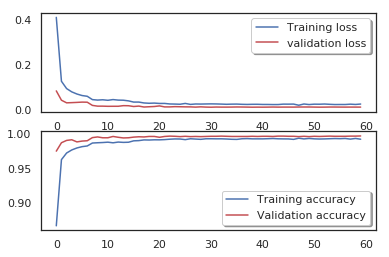

In [14]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### 4.2 Confusion matrix

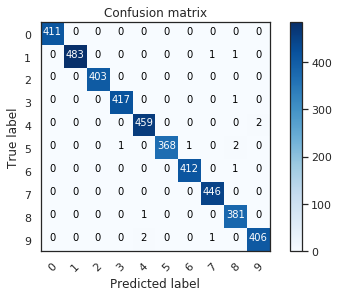

In [15]:
# Look at confusion matrix 
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

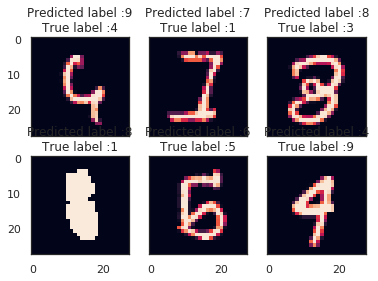

In [16]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_val[errors]

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

In [17]:
# predict results
results = model.predict(test)

# select the indix with the maximum probability
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [19]:
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("submissions/cnn_mnist_datagen.csv",index=False)